<a href="https://colab.research.google.com/github/athens-igg/dfu-models/blob/main/mobilenet%2BPSO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow
!pip install kaggle


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 726.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 96.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 136.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 125.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 6.9 MB/s eta 0:00:00


In [ ]:
from google.colab import files
files.upload()   # select kaggle.json

Saving kaggle (19).json to kaggle (19).json


{'kaggle (19).json': b'{"username":"athenkaggle","key":"b600b548dd37889b9d967b2b2fbea794"}'}

In [ ]:

!mkdir -p ~/.kaggle
!cp "kaggle (19).json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:

!kaggle datasets download -d purushomohan/dfu-wagners-classification

Dataset URL: https://www.kaggle.com/datasets/purushomohan/dfu-wagners-classification
License(s): unknown
  0% 0.00/44.6M [00:00<?, ?B/s]
100% 44.6M/44.6M [00:00<00:00, 1.54GB/s]


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:82: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


In [ ]:
!unzip -q dfu-wagners-classification.zip -d /content/drive

In [ ]:
input_train_data="/content/drive/Dataset/Training"
pso_train_data="/content/drive/pso_Dataset/PSO_Training"

input_valid_data="/content/drive/Dataset/Validation"
pso_valid_data="/content/drive/pso_Dataset/PSO_Validation"

In [ ]:
!pip install opencv-python-headless


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 MB 28.0 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm

def pso_segmentation(image, max_iter=30, swarm_size=15, w=0.7, c1=1.5, c2=1.5):
    # --- Fitness: Otsu’s between-class variance ---
    def fitness(image, threshold):
        hist = cv2.calcHist([image],[0],None,[256],[0,256]).ravel()
        hist = hist / hist.sum()
        w0 = hist[:threshold].sum()
        w1 = hist[threshold:].sum()
        if w0 == 0 or w1 == 0:
            return 0
        mu0 = np.sum(np.arange(0,threshold)*hist[:threshold]) / w0
        mu1 = np.sum(np.arange(threshold,256)*hist[threshold:]) / w1
        return w0*w1*((mu0-mu1)**2)

    # --- Initialize particles ---
    particles = np.random.randint(1,255,(swarm_size,))
    velocities = np.zeros(swarm_size)
    pbest = particles.copy()
    pbest_fitness = np.array([fitness(image, p) for p in particles])
    gbest = pbest[np.argmax(pbest_fitness)]
    gbest_fit = np.max(pbest_fitness)

    for _ in range(max_iter):
        for i in range(swarm_size):
            r1, r2 = np.random.rand(), np.random.rand()

            # --- Velocity update ---
            velocities[i] = (
                w*velocities[i]
                + c1*r1*(pbest[i] - particles[i])
                + c2*r2*(gbest - particles[i])
            )

            # --- Position update ---
            particles[i] = int(np.clip(particles[i] + velocities[i], 1, 254))

            # --- Evaluate fitness ---
            f = fitness(image, particles[i])
            if f > pbest_fitness[i]:
                pbest[i] = particles[i]
                pbest_fitness[i] = f
                if f > gbest_fit:
                    gbest = particles[i]
                    gbest_fit = f

    return gbest


In [ ]:
def process_training_dataset(input_train_data, pso_train_data):
    for cls in os.listdir(input_train_data):  # Grade 0, Grade1, Grade2, Grade3, Normal
        input_path = os.path.join(input_train_data, cls)
        output_path = os.path.join(pso_train_data, cls)
        os.makedirs(output_path, exist_ok=True)

        print(f"Processing {cls} ...")
        for img_name in tqdm(os.listdir(input_path)):
            if not img_name.lower().endswith((".png", ".jpg", ".jpeg")):
                continue
            img_path = os.path.join(input_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue

            best_thresh = pso_segmentation(img)
            _, segmented = cv2.threshold(img, best_thresh, 255, cv2.THRESH_BINARY)


            # Convert grayscale segmentation to 3-channel RGB
            segmented_rgb = cv2.cvtColor(segmented, cv2.COLOR_GRAY2RGB)

            save_path = os.path.join(output_path, img_name)
            cv2.imwrite(save_path, segmented_rgb)

        print(f"✅ Finished PSO Segmentation for {cls}.")
        print(f"   Saved in: {output_path}")



In [ ]:
# Example usage
input_train_data="/content/drive/Dataset/Training"
pso_train_data="/content/drive/pso_Dataset/PSO_Training"
process_training_dataset(input_train_data, pso_train_data)

Processing Grade 1 ...


100%|██████████| 141/141 [00:04<00:00, 30.54it/s]


✅ Finished PSO Segmentation for Grade 1.
   Saved in: /content/drive/pso_Dataset/PSO_Training/Grade 1
Processing Grade 0 ...


100%|██████████| 53/53 [00:01<00:00, 29.40it/s]


✅ Finished PSO Segmentation for Grade 0.
   Saved in: /content/drive/pso_Dataset/PSO_Training/Grade 0
Processing Normal(Healthy skin) ...


100%|██████████| 557/557 [00:18<00:00, 29.79it/s]


✅ Finished PSO Segmentation for Normal(Healthy skin).
   Saved in: /content/drive/pso_Dataset/PSO_Training/Normal(Healthy skin)
Processing Grade 2 ...


100%|██████████| 152/152 [00:04<00:00, 30.61it/s]


✅ Finished PSO Segmentation for Grade 2.
   Saved in: /content/drive/pso_Dataset/PSO_Training/Grade 2
Processing Grade 3 ...


100%|██████████| 62/62 [00:01<00:00, 31.32it/s]

✅ Finished PSO Segmentation for Grade 3.
   Saved in: /content/drive/pso_Dataset/PSO_Training/Grade 3


In [ ]:

import os
import cv2
import numpy as np
from tqdm import tqdm

def pso_segmentation(image, max_iter=30, swarm_size=15, w=0.7, c1=1.5, c2=1.5):
    # --- Fitness: Otsu’s between-class variance ---
    def fitness(image, threshold):
        hist = cv2.calcHist([image],[0],None,[256],[0,256]).ravel()
        hist = hist / hist.sum()
        w0 = hist[:threshold].sum()
        w1 = hist[threshold:].sum()
        if w0 == 0 or w1 == 0:
            return 0
        mu0 = np.sum(np.arange(0,threshold)*hist[:threshold]) / w0
        mu1 = np.sum(np.arange(threshold,256)*hist[threshold:]) / w1
        return w0*w1*((mu0-mu1)**2)

    # --- Initialize particles ---
    particles = np.random.randint(1,255,(swarm_size,))
    velocities = np.zeros(swarm_size)
    pbest = particles.copy()
    pbest_fitness = np.array([fitness(image, p) for p in particles])
    gbest = pbest[np.argmax(pbest_fitness)]
    gbest_fit = np.max(pbest_fitness)

    for _ in range(max_iter):
        for i in range(swarm_size):
            r1, r2 = np.random.rand(), np.random.rand()

            # --- Velocity update ---
            velocities[i] = (
                w*velocities[i]
                + c1*r1*(pbest[i] - particles[i])
                + c2*r2*(gbest - particles[i])
            )

            # --- Position update ---
            particles[i] = int(np.clip(particles[i] + velocities[i], 1, 254))

            # --- Evaluate fitness ---
            f = fitness(image, particles[i])
            if f > pbest_fitness[i]:
                pbest[i] = particles[i]
                pbest_fitness[i] = f
                if f > gbest_fit:
                    gbest = particles[i]
                    gbest_fit = f

    return gbest

In [ ]:
def process_validation_dataset(input_valid_data,pso_valid_data):
    for cls in os.listdir(input_valid_data):  # Grade 0, Grade1, Grade2, Grade3, Normal
        input_path2 = os.path.join(input_valid_data, cls)
        output_path2 = os.path.join(pso_valid_data, cls)
        os.makedirs(output_path2, exist_ok=True)

        print(f"Processing {cls} ...")
        for img_name in tqdm(os.listdir(input_path2)):
            if not img_name.lower().endswith((".png", ".jpg", ".jpeg")):
                continue

            img_path2 = os.path.join(input_path2, img_name)
            img2 = cv2.imread(img_path2, cv2.IMREAD_GRAYSCALE)
            if img2 is None:
                continue

            best_thresh = pso_segmentation(img2)
            _, segmented = cv2.threshold(img2, best_thresh, 255, cv2.THRESH_BINARY)

            # Convert grayscale segmentation to 3-channel RGB
            segmented_rgb2 = cv2.cvtColor(segmented, cv2.COLOR_GRAY2RGB)

            save_path2 = os.path.join(output_path2, img_name)
            cv2.imwrite(save_path2, segmented_rgb2)

        print(f"✅ Finished PSO Segmentation for {cls}.")
        print(f"   Saved in: {output_path2}")

In [ ]:
# Example usage

process_validation_dataset(input_valid_data, pso_valid_data)


Processing Grade 1 ...


100%|██████████| 16/16 [00:00<00:00, 31.67it/s]


✅ Finished PSO Segmentation for Grade 1.
   Saved in: /content/drive/pso_Dataset/PSO_Validation/Grade 1
Processing Grade 0 ...


100%|██████████| 12/12 [00:00<00:00, 31.11it/s]


✅ Finished PSO Segmentation for Grade 0.
   Saved in: /content/drive/pso_Dataset/PSO_Validation/Grade 0
Processing Normal(Healthy skin) ...


100%|██████████| 49/49 [00:02<00:00, 23.70it/s]


✅ Finished PSO Segmentation for Normal(Healthy skin).
   Saved in: /content/drive/pso_Dataset/PSO_Validation/Normal(Healthy skin)
Processing Grade 2 ...


100%|██████████| 19/19 [00:00<00:00, 30.64it/s]


✅ Finished PSO Segmentation for Grade 2.
   Saved in: /content/drive/pso_Dataset/PSO_Validation/Grade 2
Processing Grade 3 ...


100%|██████████| 20/20 [00:00<00:00, 30.35it/s]

✅ Finished PSO Segmentation for Grade 3.
   Saved in: /content/drive/pso_Dataset/PSO_Validation/Grade 3


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from sklearn.utils import class_weight
import numpy as np

# ============================
# 0) Hyperparameters
# ============================
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS_BASE = 40
EPOCHS_FINE = 25
N_CLASSES = 5
DROPOUT_RATE = 0.2
L2_WEIGHT = 1e-4

# ============================
# 1) Data Augmentation
# ============================
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.15,
    height_shift_range=0.15,
    brightness_range=[0.7, 1.3],
    shear_range=0.15,
    zoom_range=0.25,
    horizontal_flip=True,
    channel_shift_range=20.0,
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    pso_train_data,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_gen = val_datagen.flow_from_directory(
    pso_valid_data,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

# ============================
# 2) Class Weights
# ============================
y_train = train_gen.classes
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

# ============================
# 3) Mobilenetv2 Definition
# ============================
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224,224,3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(DROPOUT_RATE)(x)
output = Dense(N_CLASSES, activation="softmax", kernel_regularizer=l2(L2_WEIGHT))(x)

model = Model(inputs=base_model.input, outputs=output)

# ============================
# 4) Compile Base Model
# ============================
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# ============================
# 5) Callbacks
# ============================
checkpoint = ModelCheckpoint(
    "/content/drive/Dataset/best_pso_model.h5",
    monitor="val_loss",
    save_best_only=True,
    mode="min"
)

callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, verbose=1),
    checkpoint
]

# ============================
# 6) Train Base Model
# ============================
history = model.fit(
    train_gen,
    epochs=EPOCHS_BASE,
    validation_data=val_gen,
    class_weight=class_weights,
    callbacks=callbacks
)

# ============================
# 7) Fine-Tune Last Layers
# ============================
# Unfreeze last 30 layers
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=1e-4),  # small LR for fine-tuning
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_ft = model.fit(
    train_gen,
    epochs=EPOCHS_FINE,
    validation_data=val_gen,
    class_weight=class_weights,
    callbacks=callbacks
)




Found 965 images belonging to 5 classes.
Found 116 images belonging to 5 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 673ms/step - accuracy: 0.2742 - loss: 2.0334

31/31 ━━━━━━━━━━━━━━━━━━━━ 27s 778ms/step - accuracy: 0.2763 - loss: 2.0286 - val_accuracy: 0.2845 - val_loss: 1.5559 - learning_rate: 0.0010
Epoch 2/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 663ms/step - accuracy: 0.5135 - loss: 1.4341

31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 737ms/step - accuracy: 0.5132 - loss: 1.4352 - val_accuracy: 0.3448 - val_loss: 1.5519 - learning_rate: 0.0010
Epoch 3/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 650ms/step - accuracy: 0.5195 - loss: 1.4416

31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 726ms/step - accuracy: 0.5197 - loss: 1.4413 - val_accuracy: 0.4224 - val_loss: 1.3150 - learning_rate: 0.0010
Epoch 4/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 670ms/step - accuracy: 0.5762 - loss: 1.2828

31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 743ms/step - accuracy: 0.5764 - loss: 1.2831 - val_accuracy: 0.4397 - val_loss: 1.3097 - learning_rate: 0.0010
Epoch 5/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 676ms/step - accuracy: 0.5637 - loss: 1.2760

31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 750ms/step - accuracy: 0.5644 - loss: 1.2747 - val_accuracy: 0.4741 - val_loss: 1.2869 - learning_rate: 0.0010
Epoch 6/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 663ms/step - accuracy: 0.6128 - loss: 1.2415

31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 737ms/step - accuracy: 0.6122 - loss: 1.2413 - val_accuracy: 0.5259 - val_loss: 1.1794 - learning_rate: 0.0010
Epoch 7/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 736ms/step - accuracy: 0.6092 - loss: 1.3135 - val_accuracy: 0.5259 - val_loss: 1.2198 - learning_rate: 0.0010
Epoch 8/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 740ms/step - accuracy: 0.6293 - loss: 1.2119 - val_accuracy: 0.5086 - val_loss: 1.2391 - learning_rate: 0.0010
Epoch 9/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 733ms/step - accuracy: 0.5986 - loss: 1.1939 - val_accuracy: 0.4914 - val_loss: 1.2129 - learning_rate: 0.0010
Epoch 10/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 22s 710ms/step - accuracy: 0.6868 - loss: 1.0844 - val_accuracy: 0.5259 - val_loss: 1.2371 - learning_rate: 0.0010
Epoch 11/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 640ms/step - accuracy: 0.6609 - loss: 1.0445

31/31 ━━━━━━━━━━━━━━━━━━━━ 22s 713ms/step - accuracy: 0.6610 - loss: 1.0446 - val_accuracy: 0.5517 - val_loss: 1.1010 - learning_rate: 0.0010
Epoch 12/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 647ms/step - accuracy: 0.6599 - loss: 1.0336

31/31 ━━━━━━━━━━━━━━━━━━━━ 22s 723ms/step - accuracy: 0.6594 - loss: 1.0349 - val_accuracy: 0.6638 - val_loss: 0.9658 - learning_rate: 0.0010
Epoch 13/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 737ms/step - accuracy: 0.7249 - loss: 0.9799 - val_accuracy: 0.5948 - val_loss: 1.0633 - learning_rate: 0.0010
Epoch 14/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 750ms/step - accuracy: 0.6704 - loss: 0.9890 - val_accuracy: 0.5345 - val_loss: 1.2164 - learning_rate: 0.0010
Epoch 15/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 741ms/step - accuracy: 0.6811 - loss: 1.0366 - val_accuracy: 0.6379 - val_loss: 1.0059 - learning_rate: 0.0010
Epoch 16/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 740ms/step - accuracy: 0.6822 - loss: 1.0724 - val_accuracy: 0.5776 - val_loss: 1.0081 - learning_rate: 0.0010
Epoch 17/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 680ms/step - accuracy: 0.6248 - loss: 1.0291

31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 756ms/step - accuracy: 0.6255 - loss: 1.0281 - val_accuracy: 0.6552 - val_loss: 0.9576 - learning_rate: 0.0010
Epoch 18/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 660ms/step - accuracy: 0.6782 - loss: 1.0061

31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 734ms/step - accuracy: 0.6787 - loss: 1.0050 - val_accuracy: 0.6293 - val_loss: 0.9504 - learning_rate: 0.0010
Epoch 19/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 670ms/step - accuracy: 0.7005 - loss: 1.0242

31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 746ms/step - accuracy: 0.7002 - loss: 1.0227 - val_accuracy: 0.6552 - val_loss: 0.9404 - learning_rate: 0.0010
Epoch 20/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 670ms/step - accuracy: 0.7308 - loss: 0.8685

31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 744ms/step - accuracy: 0.7302 - loss: 0.8700 - val_accuracy: 0.6552 - val_loss: 0.9268 - learning_rate: 0.0010
Epoch 21/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 667ms/step - accuracy: 0.7365 - loss: 0.9296

31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 743ms/step - accuracy: 0.7366 - loss: 0.9284 - val_accuracy: 0.6466 - val_loss: 0.9158 - learning_rate: 0.0010
Epoch 22/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 743ms/step - accuracy: 0.7235 - loss: 0.8215 - val_accuracy: 0.5948 - val_loss: 1.0310 - learning_rate: 0.0010
Epoch 23/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 677ms/step - accuracy: 0.6996 - loss: 0.9683

31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 754ms/step - accuracy: 0.6987 - loss: 0.9689 - val_accuracy: 0.6638 - val_loss: 0.8329 - learning_rate: 0.0010
Epoch 24/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 730ms/step - accuracy: 0.7253 - loss: 0.9497 - val_accuracy: 0.6638 - val_loss: 0.9277 - learning_rate: 0.0010
Epoch 25/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 733ms/step - accuracy: 0.7295 - loss: 0.9136 - val_accuracy: 0.6466 - val_loss: 0.9617 - learning_rate: 0.0010
Epoch 26/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 766ms/step - accuracy: 0.7444 - loss: 0.8878 - val_accuracy: 0.6810 - val_loss: 0.9217 - learning_rate: 0.0010
Epoch 27/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 744ms/step - accuracy: 0.7311 - loss: 0.9710 - val_accuracy: 0.6897 - val_loss: 0.8819 - learning_rate: 0.0010
Epoch 28/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 673ms/step - accuracy: 0.7686 - loss: 0.8113
Epoch 28: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 740ms/step - accuracy: 0.7680 - loss: 0.8122 -

31/31 ━━━━━━━━━━━━━━━━━━━━ 29s 925ms/step - accuracy: 0.8402 - loss: 0.4950 - val_accuracy: 0.7155 - val_loss: 0.7809 - learning_rate: 1.0000e-04
Epoch 12/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 857ms/step - accuracy: 0.8690 - loss: 0.3913

31/31 ━━━━━━━━━━━━━━━━━━━━ 29s 933ms/step - accuracy: 0.8694 - loss: 0.3917 - val_accuracy: 0.7155 - val_loss: 0.7538 - learning_rate: 1.0000e-04
Epoch 13/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 28s 911ms/step - accuracy: 0.8875 - loss: 0.3562 - val_accuracy: 0.7328 - val_loss: 0.8098 - learning_rate: 1.0000e-04
Epoch 14/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 846ms/step - accuracy: 0.8379 - loss: 0.5316

31/31 ━━━━━━━━━━━━━━━━━━━━ 29s 921ms/step - accuracy: 0.8378 - loss: 0.5315 - val_accuracy: 0.7586 - val_loss: 0.7170 - learning_rate: 1.0000e-04
Epoch 15/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 856ms/step - accuracy: 0.8598 - loss: 0.4562

31/31 ━━━━━━━━━━━━━━━━━━━━ 29s 931ms/step - accuracy: 0.8603 - loss: 0.4549 - val_accuracy: 0.7586 - val_loss: 0.7068 - learning_rate: 1.0000e-04
Epoch 16/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 29s 923ms/step - accuracy: 0.8642 - loss: 0.3969 - val_accuracy: 0.7414 - val_loss: 0.7263 - learning_rate: 1.0000e-04
Epoch 17/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 850ms/step - accuracy: 0.8843 - loss: 0.3738

31/31 ━━━━━━━━━━━━━━━━━━━━ 29s 925ms/step - accuracy: 0.8842 - loss: 0.3748 - val_accuracy: 0.7931 - val_loss: 0.6368 - learning_rate: 1.0000e-04
Epoch 18/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 850ms/step - accuracy: 0.8719 - loss: 0.4012

31/31 ━━━━━━━━━━━━━━━━━━━━ 29s 925ms/step - accuracy: 0.8722 - loss: 0.3999 - val_accuracy: 0.8017 - val_loss: 0.5483 - learning_rate: 1.0000e-04
Epoch 19/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 29s 940ms/step - accuracy: 0.9078 - loss: 0.3234 - val_accuracy: 0.8103 - val_loss: 0.5612 - learning_rate: 1.0000e-04
Epoch 20/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 29s 943ms/step - accuracy: 0.9140 - loss: 0.3285 - val_accuracy: 0.8448 - val_loss: 0.5551 - learning_rate: 1.0000e-04
Epoch 21/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 29s 927ms/step - accuracy: 0.8943 - loss: 0.3257 - val_accuracy: 0.8017 - val_loss: 0.6814 - learning_rate: 1.0000e-04
Epoch 22/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 28s 910ms/step - accuracy: 0.9188 - loss: 0.2972 - val_accuracy: 0.7672 - val_loss: 0.6901 - learning_rate: 1.0000e-04
Epoch 23/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 860ms/step - accuracy: 0.9153 - loss: 0.3207

31/31 ━━━━━━━━━━━━━━━━━━━━ 29s 936ms/step - accuracy: 0.9152 - loss: 0.3205 - val_accuracy: 0.8017 - val_loss: 0.5402 - learning_rate: 1.0000e-04
Epoch 24/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 29s 927ms/step - accuracy: 0.9068 - loss: 0.3149 - val_accuracy: 0.8362 - val_loss: 0.5927 - learning_rate: 1.0000e-04
Epoch 25/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 854ms/step - accuracy: 0.9199 - loss: 0.2433

31/31 ━━━━━━━━━━━━━━━━━━━━ 29s 931ms/step - accuracy: 0.9194 - loss: 0.2444 - val_accuracy: 0.8793 - val_loss: 0.5398 - learning_rate: 1.0000e-04


In [ ]:
from tensorflow.keras.models import load_model

# Load the best model saved by ModelCheckpoint
best_pso_model = load_model("/content/drive/Dataset/best_pso_model.h5")

# Evaluate on validation data
val_loss, val_acc = best_pso_model.evaluate(val_gen)
print(f"Best Validation Accuracy: {val_acc*100:.2f}%")
print(f"Best Validation Loss: {val_loss:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 476ms/step - accuracy: 0.8830 - loss: 0.4842
Best Validation Accuracy: 87.93%
Best Validation Loss: 0.5398


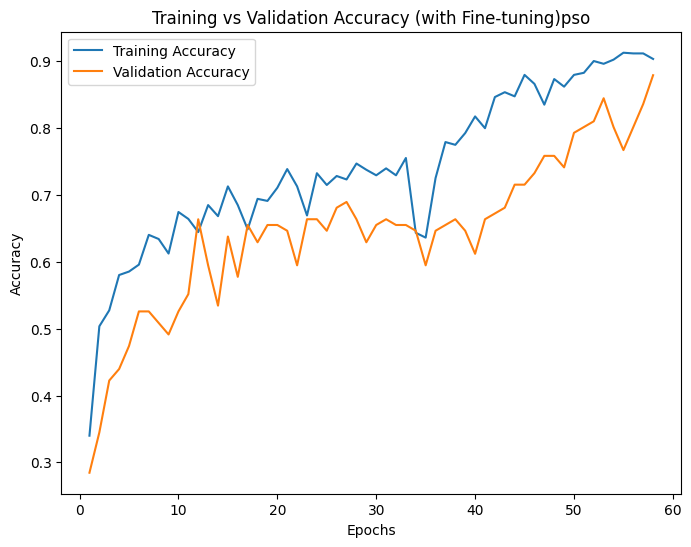

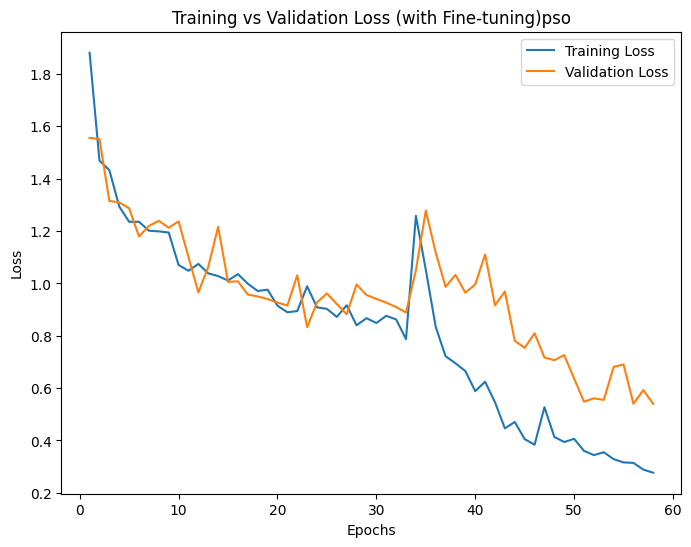

In [ ]:
import matplotlib.pyplot as plt

# Merge history and fine-tuning history
acc = history.history['accuracy'] + history_ft.history['accuracy']
val_acc = history.history['val_accuracy'] + history_ft.history['val_accuracy']
loss = history.history['loss'] + history_ft.history['loss']
val_loss = history.history['val_loss'] + history_ft.history['val_loss']

epochs_range = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(8,6))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy (with Fine-tuning)pso')
plt.legend()
plt.show()

# Plot loss
plt.figure(figsize=(8,6))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss (with Fine-tuning)pso')
plt.legend()
plt.show()


In [ ]:
model.save('/content/drive/Dataset/best_pso_model.h5')


Saving Screenshot 2025-09-21 233831.png to Screenshot 2025-09-21 233831.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step


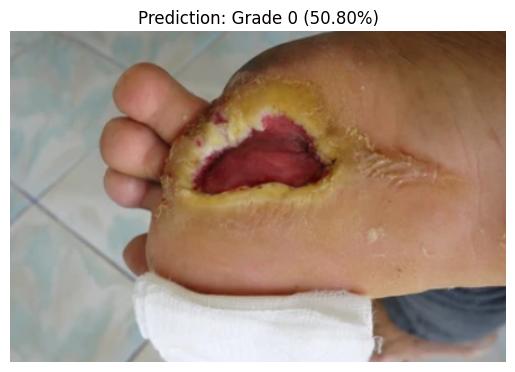

In [ ]:
!pip install opencv-python-headless
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt
# Upload image
uploaded = files.upload()
class_names = ["Grade 0", "Grade1", "Grade2", "Grade3", "Normal" ]
filename = list(uploaded.keys())[0]

# Load and preprocess image
IMG_SIZE = (224, 224)
img = cv2.imread(filename)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img_rgb, IMG_SIZE)

# Normalize same as training (rescale 1/255)
img_array = img_resized.astype("float32") / 255.0
img_array = np.expand_dims(img_array, axis=0)  # add batch dimension

# Predict
pred = best_pso_model.predict(img_array)
class_id = np.argmax(pred)
confidence = np.max(pred)

# Show result
plt.imshow(img_rgb)
plt.axis("off")
plt.title(f"Prediction: {class_names[class_id]} ({confidence*100:.2f}%)")
plt.show()

In [ ]:
model.save('best_pso_model.h5')

from google.colab import files
files.download('best_pso_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>